In [106]:
import numpy as np
import pandas as pd
import pandas_datareader.data as dt
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime

%matplotlib inline

In [107]:
def import_data(tics, start = '2010-1-1', end = datetime.today().strftime('%Y-%m-%d')):
    data = pd.DataFrame()
    if len([tics]) ==1:
        data[tics] = dt.DataReader(tics, data_source='yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for i in tics:
            data[i] = dt.DataReader(i, data_source='yahoo', start = start)['Adj Close']
    return(data)

In [109]:
def log(data):
    return (np.log(1+data.pct_change()))

In [110]:
data = import_data(['PG'])

In [111]:
def simple_returns(data):
    return ((data/data.shift(1))-1)

In [112]:
def combined_market_data(data, tic = "^GSPC", start='2010-1-1'):
    market_data = import_data(tic, start)
    market_rest = log(market_data).dropna()
    annual_return = np.exp(market_rest.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, annual_return

In [113]:
def CAPM_metrics(data, m_tic = "^GSPC", start='2010-1-1',rf_rate = 0.025):
    
    """
    Input: 
    1. data: dataframe of stock price data
    2. m_tic: ticker of the market data you want to compute CAPM metrics with (default is ^GSPC)
    3. start: data from which to download data (default Jan 1st 2010)
    4. rf_rate: the assumed risk free yield (US 10 Year Bond is assumed: 2.5%)
    
    Output:
    1. Dataframe with CAPM metrics computed against specified market procy
    """
    # Beta
    dd, ret_m = combined_market_data(data, m_tic, start)
    ret_log = log(dd)
    covar = ret_log.cov()*252
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    beta = covar/(ret_log.iloc[:,-1].var() * 252)
    
    stdev_ret = pd.DataFrame(((ret_log.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # CAPM
    for i, j in beta.iterrows():
        beta.at[i,'CAPM'] = rf_rate + (j[m_tic] * (ret_m-rf_rate))
    # Sharpe
    for i, j in beta.iterrows():
        beta.at[i,'Sharpe'] = ((j['CAPM']-rf_rate)/(j['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [114]:
CAPM_metrics(data)

,Beta,STD,CAPM,Sharpe
PG,0.56382,0.170102,0.074185,0.289147


In [115]:
def driftc(data, return_type='logarithmic'):
    if return_type=='logarithmic':
        lr = log(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    mu = lr.mean()
    var = lr.var()
    drift = mu-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [116]:
driftc(data)

array([0.00037683])

In [117]:
def daily_returns(data, n_days, iters, return_type='logarithmic'):
    drift_v = driftc(data, return_type)
    if return_type == 'logarithmic':
        try:
            st_val = log(data).std().values
        except:
            st_val = log(data).std()
    elif return_type=='simple':
        try:
            st_val = simple_returns(data).std().values
        except:
            st_val = simple_returns(data).std()    

    s = np.exp(drift_v + st_val * stats.norm.ppf(np.random.rand(n_days, iters)))
    return s

In [118]:
dr = daily_returns(data, 2, 3)

In [119]:
def threshold_prob(predicted_data, threshold, on = 'value'):
    """
    This function calculated the probability of a stock being above a certain threshhold, which can be defined as a value (final stock price) or return rate (percentage change)
    Input: 
    1. predicted_data: dataframe with all the predicted prices (days and simulations)
    2. threshold: specified threshhold to which compute the probability (ex. 0 on return will compute the probability of at least breakeven)
    3. on: 'return' or 'value', the return of the stock or the final value of stock for every simulation over the time specified
    """
    if on == 'return':
        pred_0 = predicted_data.iloc[0,0]
        pred = predicted_data.iloc[-1]
        p_list = list(pred)
        above = [(i*100)/pred_0 for i in p_list if ((i-pred_0)*100)/pred_0 >= threshold]
        below = [(i*100)/pred_0 for i in p_list if ((i-pred_0)*100)/pred_0 < threshold]
    elif on == 'value':
        pred = predicted_data.iloc[-1]
        p_list = list(pred)
        above = [i for i in p_list if i >= threshold]
        below = [i for i in p_list if i < threshold]
    else:
        print("'on' must be either value or return")
    probability=(len(above)/(len(above)+len(below)))
    return probability

In [120]:
def mc_sim(data, n_days, iters, output_type='logarithmic', plot=True):
    # Generate daily returns
    dreturns = daily_returns(data, n_days, iters, output_type)
    # Create empty matrix
    p_list = np.zeros_like(dreturns)
    # Put the last actual price in the first row of matrix. 
    p_list[0] = data.iloc[-1]
    # Calculate the price of each day
    for i in range(1,n_days):
        p_list[i] = p_list[i-1]*dreturns[i]
    
    # Plot Option
    if plot == True:
        x = pd.DataFrame(p_list).iloc[-1]
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        sns.distplot(x, ax=ax[0])
        sns.distplot(x, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
        plt.xlabel("Stock Price")
        plt.show()
    
    #CAPM and Sharpe Ratio
    
    # Printing information about stock
    try:
        [print(name) for name in data.columns]
    except:
        print(data.name)
    print(f"Days: {n_days-1}")
    print(f"Expected Value: ${round(pd.DataFrame(p_list).iloc[-1].mean(),2)}")
    print(f"Return: {round(100*(pd.DataFrame(p_list).iloc[-1].mean()-p_list[0,1])/pd.DataFrame(p_list).iloc[-1].mean(),2)}%")
    print(f"Probability of Breakeven: {threshold_prob(pd.DataFrame(p_list),0, on='return')}")
   
          
    return pd.DataFrame(p_list)

C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


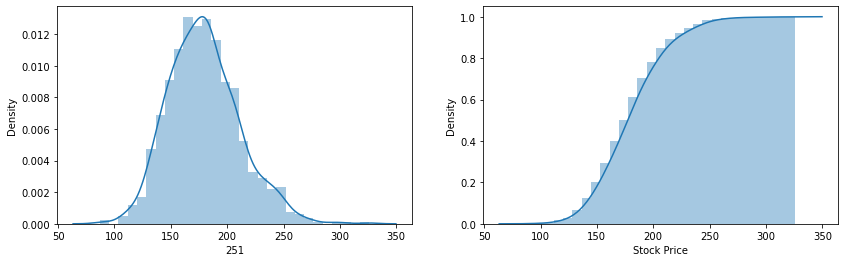

PG
Days: 251
Expected Value: $179.39
Return: 10.5%
Probability of Breakeven: 0.712


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,160.550003,160.550003,160.550003,160.550003,160.550003,160.550003,160.550003,160.550003,160.550003,160.550003,...,160.550003,160.550003,160.550003,160.550003,160.550003,160.550003,160.550003,160.550003,160.550003,160.550003
1,164.206065,159.473010,158.696129,160.912903,161.818701,159.218727,162.674145,162.562132,161.691279,159.648147,...,159.033744,158.802247,160.964293,160.376176,156.836092,157.103597,157.595155,161.362328,161.880173,160.381900
2,167.498705,158.170644,155.986361,161.777285,160.767338,157.547297,162.362625,163.299589,159.328167,159.928959,...,160.237124,157.611115,160.788411,160.741128,157.124325,156.038422,157.812008,160.661694,160.991307,161.980823
3,165.580310,159.590578,156.339219,162.594042,160.953539,155.409947,161.193195,161.892806,158.410703,159.003371,...,159.076341,160.161400,159.775905,160.920370,157.463009,155.399026,155.945043,159.168791,156.907013,161.458355
4,165.977595,160.128508,156.070522,165.835020,162.663564,156.371364,159.886800,161.305572,158.232433,161.363890,...,159.790534,161.851997,157.370268,160.468383,158.791465,153.997094,156.821982,163.000227,155.654258,163.213638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,166.850482,211.045850,171.661253,205.341880,150.929286,156.140100,218.207245,176.075430,171.781014,172.019536,...,176.339550,185.509614,122.750025,159.690329,158.052587,137.199336,169.211339,241.828798,167.692608,191.921991
248,168.898311,209.065405,171.695751,206.065995,148.990934,154.158700,218.306072,174.369793,173.643694,173.072117,...,176.688016,184.984925,123.978250,161.416850,161.450817,138.860682,167.956611,242.875853,169.088680,190.690725
249,169.050551,210.631893,169.300868,209.458919,149.827541,150.909419,218.242137,175.770518,174.176547,172.462148,...,177.774649,186.092081,122.454588,160.686581,160.256468,139.282946,167.973759,247.959856,172.414031,191.706735
250,167.476908,211.458838,168.267008,207.344564,150.848142,153.031542,219.407245,175.967856,175.541774,172.650801,...,176.686144,187.896691,123.243829,158.244805,159.796379,138.285426,169.381435,248.815694,171.552980,191.402827


In [121]:
mc_sim(data, 252, 1000, 'logarithmic')

In [122]:
def monte_carlo(tic, days_forecast, iters, start_date = '2010-1-1', output_type = 'logarithmic', plots=False):
    stock_data = import_data(tic, start=start_date)
    metrics = CAPM_metrics(stock_data, m_tic="^GSPC", start=start_date)
    sim_data = []
    for i in range(len(tic)):
        y = mc_sim(stock_data.iloc[:,i], (days_forecast+1), iters, output_type)
        if plots == True:
            forplot = y.iloc[:,0:10]
            forplot.plot(figsize=(15,4))
        print(f"Beta: {round(metrics.iloc[i,metrics.columns.get_loc('Beta')],2)}")
        print(f"Sharpe: {round(metrics.iloc[i,metrics.columns.get_loc('Sharpe')],2)}") 
        print(f"CAPM Return: {round(100*metrics.iloc[i,metrics.columns.get_loc('CAPM')],2)}%")
        y['ticker'] = tic[i]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        sim_data.append(y)
    sim_data = pd.concat(sim_data)
    return sim_data

C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


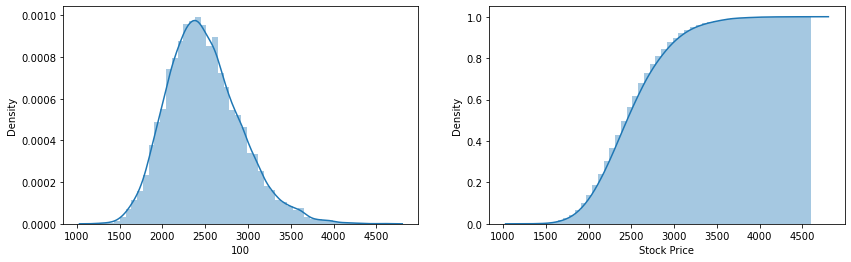

GOOG
Days: 100
Expected Value: $2487.34
Return: 7.56%
Probability of Breakeven: 0.6441
Beta: 1.09
Sharpe: 0.3
CAPM Return: 10.64%


C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


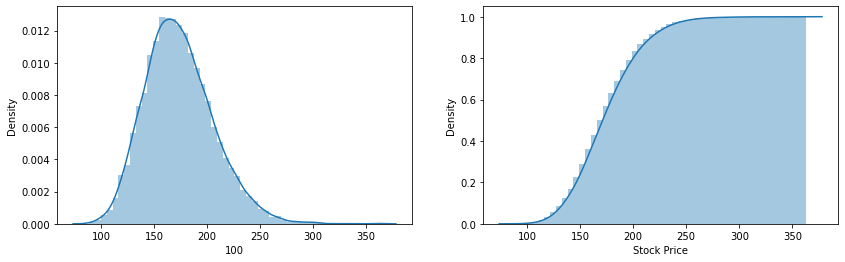

AAPL
Days: 100
Expected Value: $173.84
Return: 9.31%
Probability of Breakeven: 0.6709
Beta: 1.19
Sharpe: 0.31
CAPM Return: 11.37%


C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


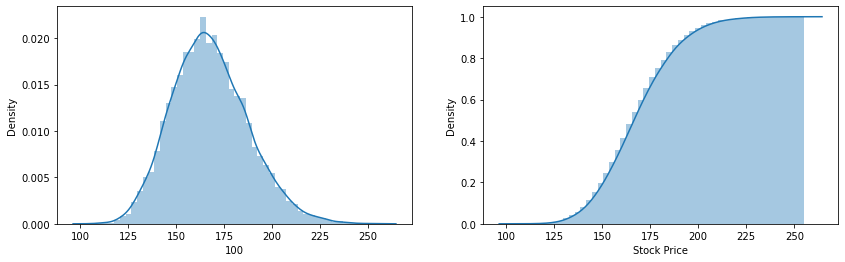

PG
Days: 100
Expected Value: $167.71
Return: 4.27%
Probability of Breakeven: 0.6223
Beta: 0.6
Sharpe: 0.24
CAPM Return: 7.02%


In [123]:
start = "2015-1-1"
days_to_forecast= 100
simulation_trials= 10000
ret_sim_df = monte_carlo(['GOOG','AAPL','PG'], days_forecast= days_to_forecast, iters=simulation_trials,  start_date=start, plots=False)

C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


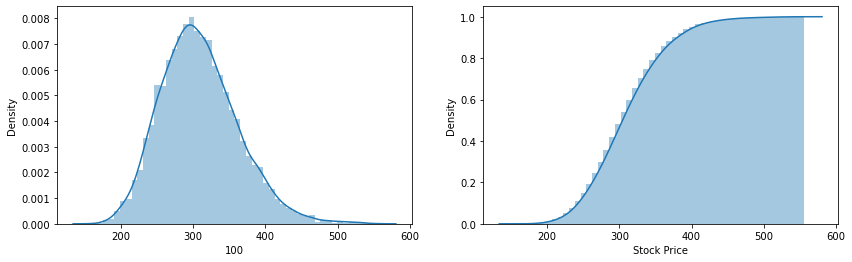

MSFT
Days: 100
Expected Value: $308.79
Return: 10.13%
Probability of Breakeven: 0.7048
Beta: 1.21
Sharpe: 0.33
CAPM Return: 11.53%


C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


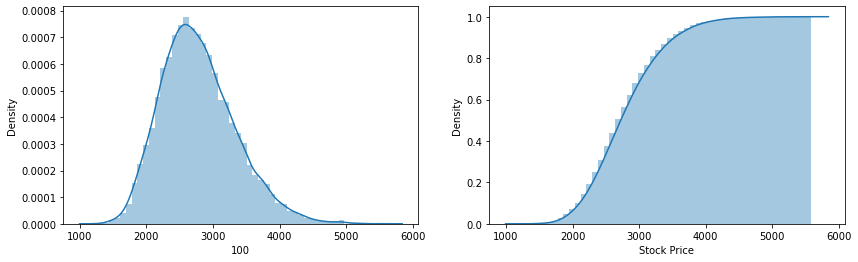

AMZN
Days: 100
Expected Value: $2780.66
Return: 10.61%
Probability of Breakeven: 0.6769
Beta: 1.02
Sharpe: 0.24
CAPM Return: 10.12%


C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


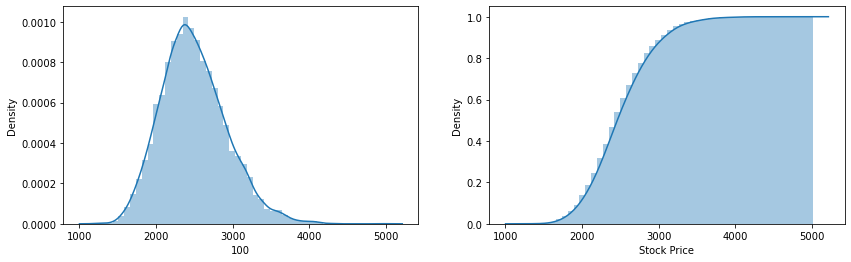

GOOG
Days: 100
Expected Value: $2494.89
Return: 7.84%
Probability of Breakeven: 0.659
Beta: 1.09
Sharpe: 0.3
CAPM Return: 10.64%


C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


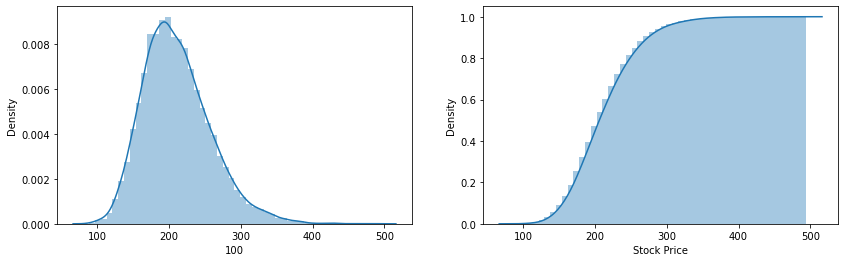

FB
Days: 100
Expected Value: $211.36
Return: 5.15%
Probability of Breakeven: 0.5467
Beta: 1.17
Sharpe: 0.25
CAPM Return: 11.24%


In [125]:
start = "2015-1-1"
days_to_forecast= 100
simulation_trials= 10000
ret_sim_df = monte_carlo(['MSFT','AMZN','GOOG','FB'], days_forecast= days_to_forecast, iters=simulation_trials,  start_date=start, plots=False)

In [104]:
stock_data1 = import_data(['FB'],start=start)
stock_data2 = import_data(['MSFT'],start=start)
stock_data3 = import_data(['GOOG'],start=start)
stock_data4 = import_data(['JNJ'],start=start)

Text(0.5, 1.0, 'Facebook')

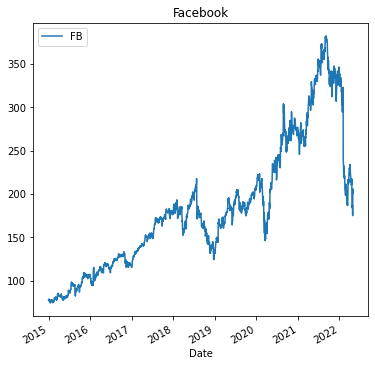

In [83]:
stock_data1.plot(figsize=(6,6))
plt.title('Facebook')

Text(0.5, 1.0, 'Microsoft')

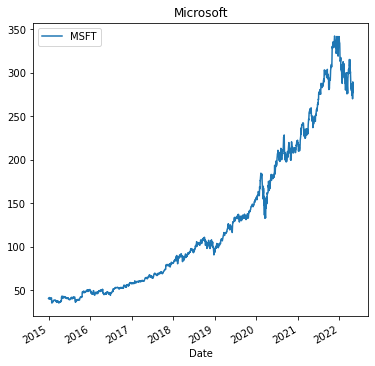

In [84]:
stock_data2.plot(figsize=(6,6))
plt.title('Microsoft')

Text(0.5, 1.0, 'Google')

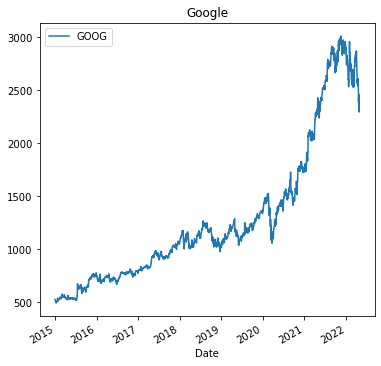

In [85]:
stock_data3.plot(figsize=(6,6))
plt.title('Google')

Text(0.5, 1.0, 'Johnson and Johnson')

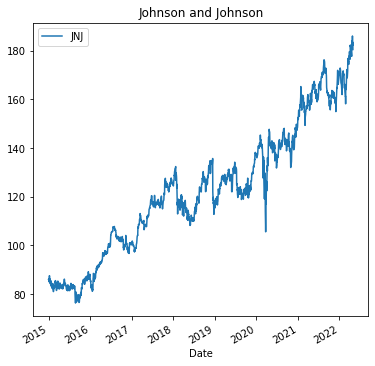

In [89]:
stock_data4.plot(figsize=(6,6))
plt.title('Johnson and Johnson')

In [81]:
pg=stock_data['PG'].to_numpy()
goog=stock_data['GOOG'].to_numpy()
appl=stock_data['AAPL'].to_numpy()

C:\Users\tw93\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

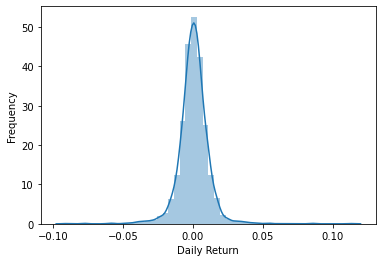

In [86]:
log_return = log(stock_data)
sns.distplot(log.iloc[1:,0])
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

In [91]:
days=50
log_returns=log(stock_data1)
stdev = log_returns.std()
days = 50
trials = 10000
u = log_returns.mean()
var = log_returns.var()
drift = u - (0.5*var)
Z = stats.norm.ppf(np.random.rand(days, trials)) #days, trials
daily_returns = np.exp(drift.values + stdev.values*Z)
price_paths = np.zeros_like(daily_returns)
price_paths[0] = data.iloc[-1]
for t in range(1, days):
    price_paths[t] = price_paths[t-1]*daily_returns[t]

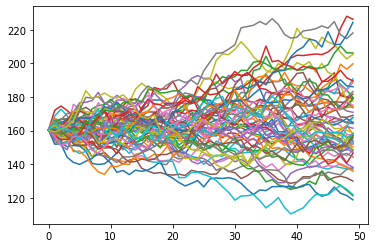

In [101]:
fig,ax=plt.subplots()
for i in range(60):
    _=ax.plot(price_paths[:,i])